# RESULTS


### Scoring

In classification problems, we can distinguish between the following metrics, whereby **the positive class is Charge Off** and **the negative class is Fully Paid**:

- **Recall or Sensitivity or TPR (True Positive Rate)**: Number of loans correctly identified as positive (fully paid) out of total true positives - TP/(TP+FN)
    
- **Specificity or TNR (True Negative Rate)**: Number of loans correctly identified as negative (charged-off) out of total negatives - TN/(TN+FP)

- **Precision**: Number of loans correctly identified as positive (fully paid) out of total items identified as positive - TP/(TP+FP)
    
- **False Positive Rate or Type I Error**: Number of loans wrongly identified as positive (fully paid) out of total true negatives - FP/(FP+TN)
    
- **False Negative Rate or Type II Error**: Number of loans wrongly identified as negative (charged-off) out of total true positives - FN/(FN+TP)

- A **Confusion Matrix**: visual representation of the number of TP, TN, FP and FN.

- **Accuracy**: Percentage of total items classified correctly - (TP+TN)/(N+P)

- **F1 Score**: Harmonic mean of precision and recall given by - F1 = 2xPrecisionxRecall /(Precision + Recall)

- **ROC-AUC Score**: Area under curve of sensitivity (TPR) vs. specificity (TNR).

- **Log-loss**: Probabilistic confidence of accuracy. High value of log-loss means that the absolute probabilities have big difference from actual labels.  

**Scoring in investment strategy**

Insights from [8] were used in this section.

If we choose an investment strategy that uses absolute probabilistic difference, then we will  look at log-loss with care. If the final class prediction is the most important outcome and we don’t want to tune probability threshold, we will rather use AUC score. But if the threshold is well tuned, then F1 will be the scoring to use.

In loan classification, where positive labels (charged-offs) are few, we would like our model to predict positive classes correctly and hence we will sometime prefer those models which are able to classify these positive labels. Log-loss usually fails to identify model which produces too many false negatives because the log-loss function is symmetric and does not differentiate between classes.  Both F1 score and ROC-AUC score can perform well for class imbalance. F1 is better suit for situations where the negative class is small. Since an investor would care more about the minority class (charged-off loans) in number independent of the fact whether it is positive or negative, then **we think that ROC-AUC score would make sense as benchmark measure.**

## Logistic Regression (Simplest Model)

We will start with a simple logistic regression model for predicting loan charge-off. The penalty parameter is found via cross-validation on the training set.

In [0]:
log_reg = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
    )

LogisticRegressionCV:
Accuracy score on training set is 76.18%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


K-fold cross-validation results on validation set:
 average accuracy is 72.13%
 average F1 is 72.85%
 average roc_auc is 78.98%


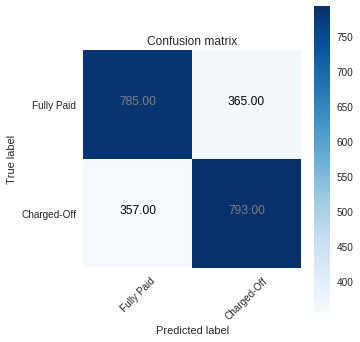

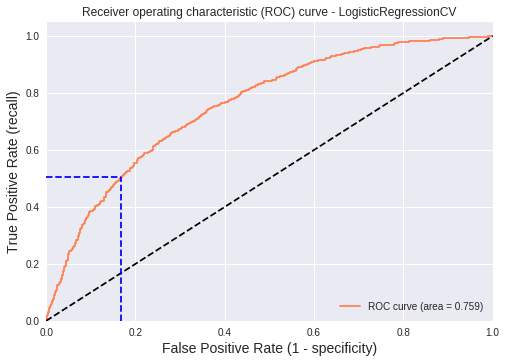

Using a threshold of 0.625 guarantees a sensitivity of 0.505 and a specificity of 0.832, i.e. a false positive rate of 16.78%.


In [0]:
log_reg = fit_predict_evaluate(log_reg, X_train_scaled, y_train, X_val_scaled, y_val, df_cv_scores)

## Random Forest (Complex Model)

We will now rebuilt our random forest classifier, this time using the important features.

In [0]:
randomf_optim = RandomForestClassifier(n_estimators=200, max_depth=20)

RandomForestClassifier:
Accuracy score on training set is 100.00%
K-fold cross-validation results on validation set:
 average accuracy is 88.06%
 average F1 is 84.70%
 average roc_auc is 97.44%


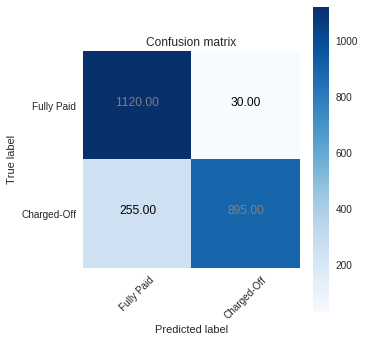

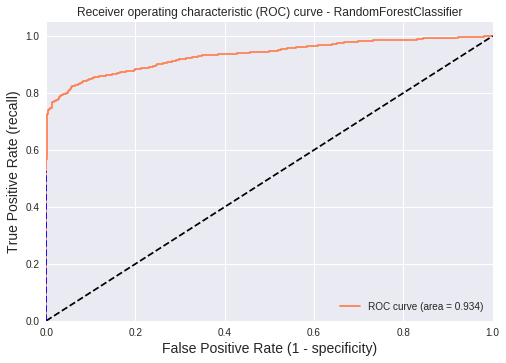

Using a threshold of 0.770 guarantees a sensitivity of 0.524 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [0]:
randomf_optim = fit_predict_evaluate(randomf_optim, X_train, y_train, X_val, y_val, df_cv_scores)

The random forest classifier gives the best accuracy so far.

## Model Selection

### Scoring benchmark

All models investigated in this project are compared in the table below. The performance was evaluated in a out-of-sample manner on the validation set using 3-folds cross-validation.

For each model, we can compare different metrics (accuracy, F1, ROC_AUC). We are also able to compare models using the metric ROC_AUC, which reflect their performance when we set probability cutoff at 50%. 

The scoring results is summarised below.

In [0]:
df_cv_scores_report = df_cv_scores.copy()
df_cv_scores_report.drop('model', inplace=True, errors='ignore')
df_cv_scores_report.sort_values(by=['roc_auc'], ascending=False, inplace=True)
df_cv_scores_report.reset_index(inplace=True)
df_cv_scores_report.rename(columns={'index':'model'}, inplace=True)
df_cv_scores_report

,model,accuracy,f1,roc_auc
0,RandomForestClassifier,0.880562,0.846969,0.974449
1,XGBClassifier,0.845373,0.792185,0.947335
2,MLPClassifier,0.818710,0.850022,0.905519
3,QuadraticDiscriminantAnalysis,0.728248,0.778674,0.886444
4,AdaBoostClassifier,0.848811,0.818505,0.886048
5,KNeighborsClassifier,0.796090,0.827522,0.884272
6,DecisionTreeClassifier,0.797905,0.783813,0.805290
7,LogisticRegressionCV,0.721318,0.728491,0.789766
8,SVC,0.712191,0.720923,0.783381
9,MultinomialNB,0.830869,0.907093,0.558796


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  confint = []


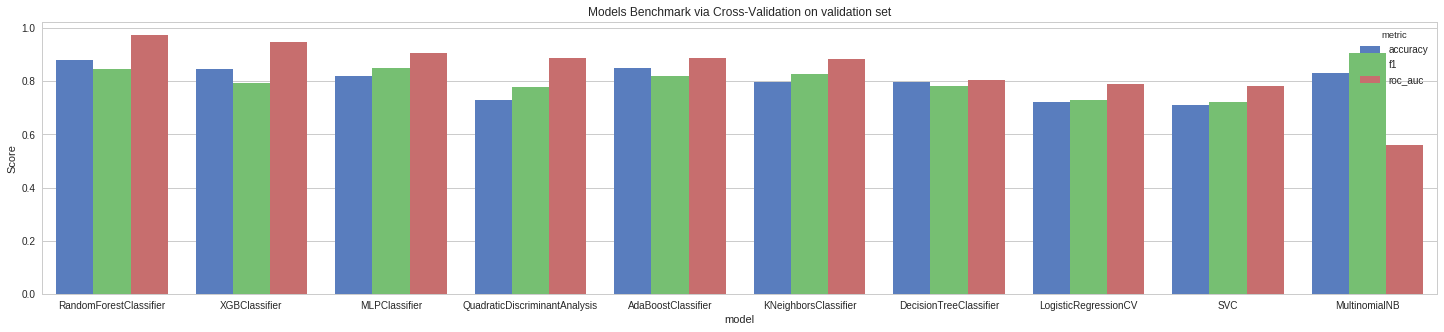

In [0]:
df_cv_scores_melt = pd.melt(df_cv_scores_report, id_vars=['model'], var_name='metric', value_name='score')
fig, ax = plt.subplots(1,1,figsize=(25,5))
sns.set(style="whitegrid")
sns.barplot(x="model", y="score", hue="metric", data=df_cv_scores_melt, palette="muted", ax=ax)
ax.set_title("Models Benchmark via Cross-Validation on Validation set")
ax.set_ylabel("Score");

Some models were also evaluated on a scaled version of the data (with features standardized with zero mean and standard deviation 1). The results below show that standardizing the data did not improve the prediction accuracy.

# Final Model

#### Random Forest Classifier is the best performer with CV accuracy of 88.05%, Area under ROC of 0.9744 and F1 score of 0.8469

**Threshold tuning**

It is more flexible to predict probabilities of a loan belonging to each class rather than predicting classes directly. Probabilities may be interpreted using different thresholds that allow us to trade-off concerns in the errors made by the model, such as the number of false negatives which outweighs the cost of false positives. We will use ROC Curves and Precision-Recall curves as diagnostic tools.

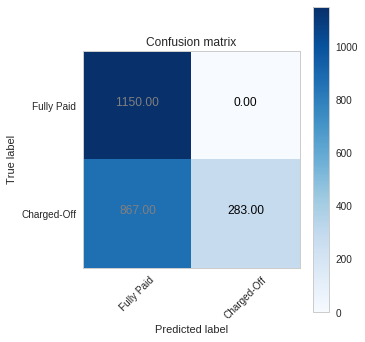

In [0]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=.9)

As shown above if we set the threshold too high, we end up with a very bad prediction of Charge Offs. Although we predict all Fully Paid loans right, our investor will have to deal with a very high number of loans failures.

Below, by choosing a lower threshold the investor will miss some business opportunities, but will secure his finance by correctly identifying those loans with high risk of failures.

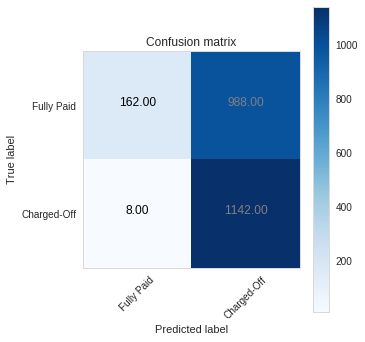

In [0]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=.1)

By choosing a **threshold of 0.3**, we have ca. 12% of false positives. These are loans which have charged off but our model failed to identify them. We will assume that such a threshold is an acceptable compromise for our investment strategy. 

In [0]:
threshold = .3

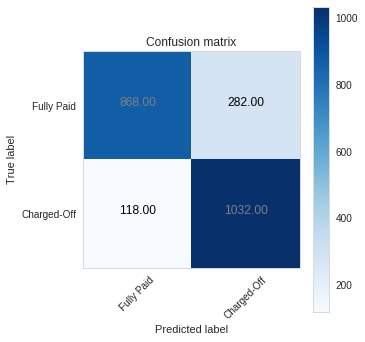

In [0]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=threshold)

### ROC benchmark

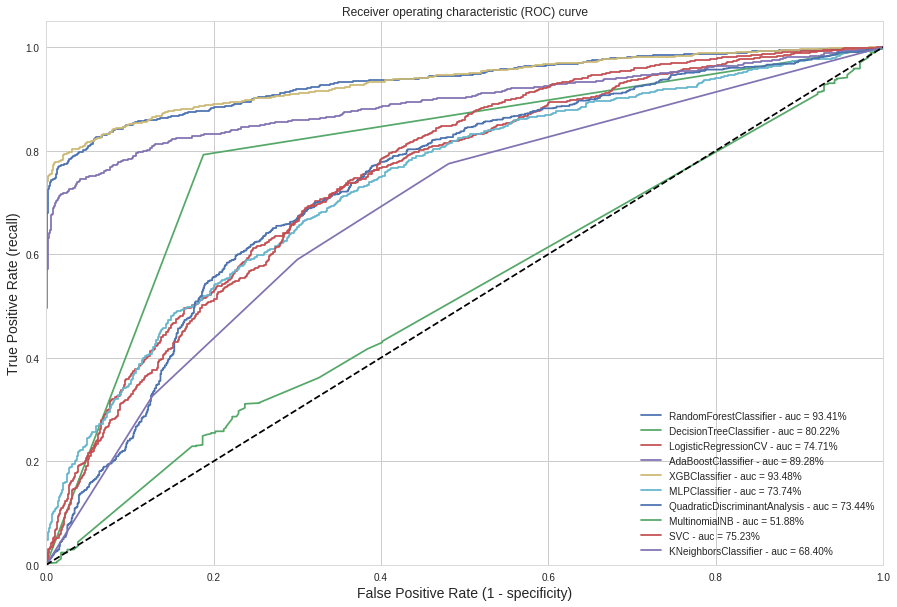

In [0]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
models = [randomf_optim, dt_model, log_reg, ab_model, xgb_model, mlp_model, qda_model, nb_model, svm_model, knn_model]
for model in models:
    model_name = model.__class__.__name__
    if  model_name == 'RandomForestClassifier' or \
        model_name == 'XGBClassifier' or \
        model_name == 'AdaBoostClassifier' or \
        model_name == 'DecisionTreeClassifier':
        Xval = X_val
        yval = y_val
    elif model_name == 'MultinomialNB':
        Xval = X_val_desc_features
        yval = y_val_desc
    else:
        Xval = X_val_scaled
        yval = y_val
    y_pred = df_y_preds[model_name]
    y_pred_proba = df_y_pred_probas[model_name]
    [fpr, tpr, thr] = roc_curve(yval, y_pred_proba)
    
    ax.plot(fpr, tpr, label='{0} - auc = {1:.2%}'.format(model_name,auc(fpr, tpr)))
    if model_name == 'RandomForestClassifier':
        idx = np.min(np.where(tpr > threshold))
        ax.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', label='', color='b')
        ax.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', label='', color='b')
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Combining all predictions and creating a heatplot of their correlations gives us the following view. Supoprt Vector Machine is excluded from this plot since it computes distances instead of probabilities, which can only be estimated at the cost of extensive computation. 

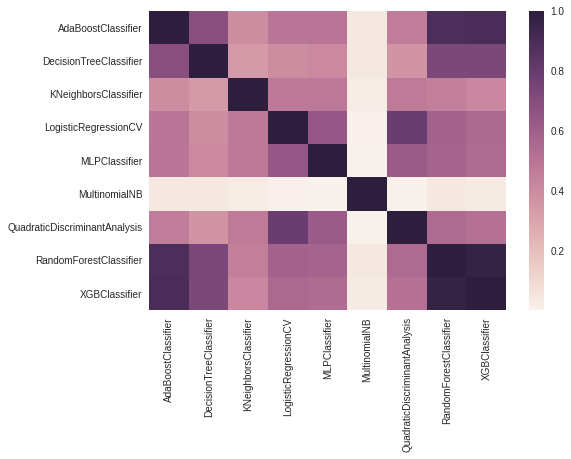

In [0]:
df_y_val_prob = df_y_pred_probas[df_y_pred_probas.columns.difference(['SVC'])]
sns.heatmap(df_y_val_prob.corr())
plt.show()

It is pretty clear from these visualizations that the predictions of Naive Bayes classifier, Multilayer Perceptron, QDA, Logistic Regression are very opposite from predictions of other models. The tree-based classifiers are producing rvery similar results to each other, showing their similar internal structure. The predictions of KNN classifier are also very less correlated with the predictions of other classifiers. 

Below we compute the Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores using the average probabilities from our classifiers (excluding support vector machine).

In [0]:
y_val_pred_avg = adjust_proba(df_y_val_prob.mean(axis=1), threshold)
avg_score = roc_auc_score(y_val, y_val_pred_avg)

In [0]:
y_val_pred_rf = df_y_preds['RandomForestClassifier']
rf_score = roc_auc_score(y_val, y_val_pred_rf)

In [0]:
print("With probability threshold {} on validation set", threshold)
print("  ROC AUC score obtained by averaging probabilities of several classifiers is {0:.2%}".format(avg_score))
print("  ROC AUC score obtained by the Random Forest Classifier is {0:.2%})".format(rf_score))

With probability threshold {} on validation set 0.3
  ROC AUC score obtained by averaging probabilities of several classifiers is 73.61%
  ROC AUC score obtained by the Random Forest Classifier is 87.61%)


This result suggests that an Ensemble technique, e.g. Stacking would most probably not bring considerable improvment in the reduction of false negatives (loan predicted fully paid, but in reality charge off). 

## Return on Investment (ROI)

Accuracy, ROC, MSE, are terms familiar to a data scientist but, probably not terms an investor would easilly understand. One of the most common metrics to evaluate an investment is Return On Investment (ROI) which can be defined as (FinalValue - InitialValue)/InitialValue. For example, we invest \\$1000 and after a year, our investment is worth \$1200, then our annual ROI is 20%.

We will test our strategy using the 2015 LC loan stats data. 15.68% of the loans in the dataset are classified as False (failed).<br><br>
The goal is to select loans such that the failure rate is less than 15.68%. At this point we are assumung that a selection of loans from the same grade (same interest rate) with a failure rate lower than 15.68% will yield a better ROI for the investor. This needs to be verified and involves looking at the costs of failed loans.<br><br>
The Random Forest model that was developed in the previous section is used here since it clearly outperformed many different models we have been trying based on the ROC_AUC metric. <br><br>
A failure rate of 15.68% or more which sounds excellent, but is indeed no better than a random loan selection.<br><br>
Our Business Objective is to minimize the percentage of Loans selected which are False. This is referred to as the "False Discovery Rate" (FDR). It is equal to 1 - PPV (Positive Prediction Value) [13]. We may reject many loans which are good loans; however, we do not want to select loans that are bad ones.<br><br>

As we saw in the confusion matrix in the previous sections, let's think about what happens when we reduce the threshold from, 50% to 30%. In this case, some loans which would have normally be classified as Fully Paid will be classified as Charge Off. However, the loans that are selected have a higher probability of truly being Charge Off (actual value). Similarly the probability of a selected loan failing will drop. Hence decreasing the threshold increases the quality of the selection with the trade-off that we are throwing away (not selecting) loans which would normally be classified as Good. 

In the next sections we will evaluate this strategy in loans of the same subgrade, as assigned by the LendingClub.

## Prediction

Now it is time to evaluate our model on the left-out data set, which has not been used neither for training nor for cross-validation.

In [0]:
y_test_pred = randomf_optim.predict_proba(X_test)[:, 1]
y_test_pred = adjust_proba(y_test_pred, threshold)
test_score = accuracy_score(y_test, y_test_pred)
print("With probability threshold {0}, the Classification Accuracy Score on Test is {1:.2%}".format(threshold, test_score))

With probability threshold 0.3, the Classification Accuracy Score on Test is 71.06%


These are compeling results showing that the model separates fully paid from charge-off loans with high accuracy on unseen data.

In [0]:
print("Without our model, the accuracy on Test would have been {0:.2%}".format(1-len(y_test[y_test==1])/len(y_test)))

Without our model, the accuracy on Test would have been 81.82%


## Evaluation

The function below fits a predictive model with a subset of data depending on the invesment strategy (sub grades and term), and it displays the accuracy of our predictions, as well as an estimation of the Return Of Investment campared to the default strategy offered by LendingClub.

In [0]:
def simulate_strategy(df, X_test_df, X_test, sub_grades=['A1'], terms=[36], threshold=.3, verbose=True):
    # indexes of test loans in the original data frame containing all loans
    test_idx = X_test_df.index.values
    # test loans from the original data frame containing all loans
    df_test = df.loc[test_idx]
    # subset of candidate test loans, filtered by specific sub grades and terms
    df_test_candidates = df_test[(df_test.sub_grade.isin(sub_grades)) & (df_test.term.isin(terms))]
    if df_test_candidates.shape[0] == 0:
        return 0, 0
    # indexes of candidate test loans
    df_test_candidates_idx = df_test_candidates.index.values
    # candidate test loans in the design matrix
    X_test_candidates = X_test[df_test.index.isin(df_test_candidates_idx)]
    y_test_candidates = y_test[df_test.index.isin(df_test_candidates_idx)]
    # prediction of loan status for candidate test loans
    y_test_candidates_pred = randomf_optim.predict_proba(X_test_candidates)[:, 1]
    y_test_candidates_pred = adjust_proba(y_test_candidates_pred, threshold)
    test_score = accuracy_score(y_test_candidates, y_test_candidates_pred)
    df_test_candidates = df_test_candidates.assign(loan_status_predicted = y_test_candidates_pred)
    # calculate the ROI for each candidate test loan
    df_test_candidates['roi'] = df_test_candidates.apply(calc_roi, axis=1)
    # calculate average annual ROI for the Lender's CLub 'Automatic' selection
    roi_lc = df_test_candidates['roi'].mean()
    # calculate average annual ROI for loans which our model predicts they will be fully paid (prediction is 0)
    roi_randomf = df_test_candidates[df_test_candidates.loan_status_predicted==0]['roi'].mean()
    # display results
    if verbose:
        print('Investment on sub grades {} and terms {}:'.format(sub_grades, terms))
        print('')
        print("  With probability threshold {0}, the selected loans were classified with accuracy {1:.2%}".format(threshold, test_score))
        print("  Average annual ROI for Lending Club is {}%".format(round(roi_lc,2)))
        print("  Average annual ROI for our model is {}%".format(round(roi_randomf,2)))
    return roi_lc, roi_randomf

In [0]:
#
# Calculate ROI. Monthly data and much better documentation from Lender's Club is needed
# to precisely calculate ROI. Still, this is not bad!
#
def calc_roi(row):
# We assume here that  charge-offs are made in the last month
    def insuf_payment(factor, i):

        loss = int_rcvd + pmt_rcvd + net_recoveries +late_fees - owed
        factor *= (1 + loss/principal)
        factor = factor**(1/term)
        return factor**12 - 1
    
    def early_payoff(factor, i):
        return (factor**(1/(i+1)))**12 - 1 
        
    term = row.term
    int_rcvd = row.total_rec_int
    pmt_rcvd = row.total_pymnt
    principal = row.funded_amnt
    yr_int_rate = row.int_rate
    mo_int_rate = (1+yr_int_rate)**(1/12) - 1
    mo_pay = row.installment
    
    recoveries = row.recoveries
    late_fees = row.total_rec_late_fee
    fee = row.collection_recovery_fee
    
    net_recoveries = recoveries - fee
    
    owed = principal

# Calculate monthly gain (could be less than 1) while there are months to go and interest
# Could be extra interest because of hardship plans
    factor = 1

#---Beginning of For------------------------
    for i in range(0, int(term)):

        if (pmt_rcvd + .50 < mo_pay):
             return insuf_payment(factor, i)
        this_interest = owed*mo_int_rate     
        
# If not enough interest was paid to cover this month, consider loan paid off early
# and count monthly gain as (1+mo_int_rate), just like NAR

        factor *= 1 + mo_int_rate

        if (this_interest > int_rcvd):
            return early_payoff(factor, i)
            
        int_rcvd -= this_interest
        if owed < mo_pay:
            return early_payoff(factor, i)
        pmt_rcvd -= mo_pay
        owed -= mo_pay - this_interest
#---End of For-------------------------------
    return early_payoff(factor, i)

We can simulate an improved return of investment on specific loans types below.

In [0]:
roi_lc, roi_df = simulate_strategy(df_loan_accepted_census_cleaned, 
                                                               X_test_df, X_test, 
                                                               sub_grades=['D5'], 
                                                               terms=[36], 
                                                               threshold=.3)

Investment on sub grades ['D5'] and terms [36]:

  With probability threshold 0.3, the selected loans were classified with accuracy 50.00%
  Average annual ROI for Lending Club is 18.42%
  Average annual ROI for our model is 17.5%


We can simulate the model on all sorts of subgrades/terms combinations

In [0]:
sub_grades = df_loan_accepted_census_cleaned.sub_grade.unique()
terms = df_loan_accepted_census_cleaned.term.unique()
df_roi = pd.DataFrame(columns=['sub_grad', 'term', 'lc_roi', 'model_roi'])
i = 0
for sub_grade in sub_grades:
    for term in terms:
        roi_lc, roi_model = simulate_strategy(df_loan_accepted_census_cleaned, 
                                           X_test_df, X_test, 
                                           sub_grades=[sub_grade], 
                                           terms=[term], 
                                           threshold=threshold,
                                           verbose=False)
        df_roi.loc[i]=[sub_grade, term, roi_lc, roi_model]        
        i += 1

In [0]:
df_roi.lc_roi.mean(), df_roi.model_roi.mean()

(13.463904299536987, 10.33726582126489)